In [1]:
! pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


In [2]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Mounted at /content/drive


In [3]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()

In [4]:
# import the necessary packages
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from loader_util.preprocessing import ImageToArrayPreprocessor
from loader_util.preprocessing import AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import MinVGGNet
from tensorflow.keras.optimizers import SGD


In [5]:
# set the script constants
dataset_path = r"/content/drive/MyDrive/Colab Notebooks/ImageDataset/book2/flowers17/images"
n_epochs = 100

In [6]:
print(f"[INFO] loading images......")
image_paths = list(paths.list_images(dataset_path))
class_names = [pth.split(os.path.sep)[-2] for pth in image_paths]
class_names = list(np.unique(class_names))
class_names

[INFO] loading images......


['bluebell',
 'buttercup',
 'coltsfoot',
 'cowslip',
 'crocus',
 'daffodil',
 'daisy',
 'dandelion',
 'fritillary',
 'iris',
 'lilyvalley',
 'pansy',
 'snowdrop',
 'sunflower',
 'tigerlily',
 'tulip',
 'windflower']

In [7]:
# init the preprocessors
aap = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()

# load the dataset into memeory and then scale pixels
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
data, labels = sdl.load(image_paths, verbose=500)
data = data.astype("float") / 255.0

[INFO] processed 500/1360
[INFO] processed 1000/1360


In [8]:
trainx, testx, trainy, testy = train_test_split(data, labels,
                                                test_size=0.25,
                                                random_state=42)

# encode the labels
lb = LabelBinarizer()
trainy = lb.fit_transform(trainy)
testy = lb.transform(testy)

In [9]:
# init the optimizer and model
print(f"[INFO] compiling model......")
opt = SGD(learning_rate=0.05)
model = MinVGGNet.build(64, 64, 3, classes=len(class_names))
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model......


In [10]:
print(f"[INFO] training network......")
H = model.fit(trainx, trainy, validation_data=(testx, testy),
              batch_size=32, epochs=n_epochs, verbose=1)

[INFO] training network......
Epoch 1/100
32/32 [==============================] - 14s 45ms/step - loss: 3.1810 - accuracy: 0.2363 - val_loss: 3.3865 - val_accuracy: 0.0912
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 2.0272 - accuracy: 0.4137 - val_loss: 2.4007 - val_accuracy: 0.2500
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 1.4149 - accuracy: 0.5765 - val_loss: 2.6198 - val_accuracy: 0.1824
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 1.1363 - accuracy: 0.6353 - val_loss: 3.4896 - val_accuracy: 0.1324
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8790 - accuracy: 0.7118 - val_loss: 2.9726 - val_accuracy: 0.2324
Epoch 6/100
32/32 [==============================] - 1s 20ms/step - loss: 0.5692 - accuracy: 0.8137 - val_loss: 2.4440 - val_accuracy: 0.2735
Epoch 7/100
32/32 [==============================] - 1s 20ms/step - loss: 0.4697 - accuracy: 0.8500 - val_loss: 3.016

[INFO] evaluating network...
11/11 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

    bluebell       0.46      0.55      0.50        20
   buttercup       0.60      0.75      0.67        20
   coltsfoot       0.61      0.69      0.65        16
     cowslip       0.33      0.53      0.41        19
      crocus       0.58      0.47      0.52        15
    daffodil       0.38      0.30      0.33        20
       daisy       0.79      0.65      0.71        23
   dandelion       0.73      0.59      0.65        27
  fritillary       0.70      0.84      0.76        19
        iris       0.89      0.76      0.82        21
  lilyvalley       0.59      0.56      0.57        18
       pansy       0.86      0.75      0.80        16
    snowdrop       0.56      0.64      0.60        22
   sunflower       0.96      0.96      0.96        23
   tigerlily       0.86      0.67      0.75        18
       tulip       0.25      0.20      0.22        20

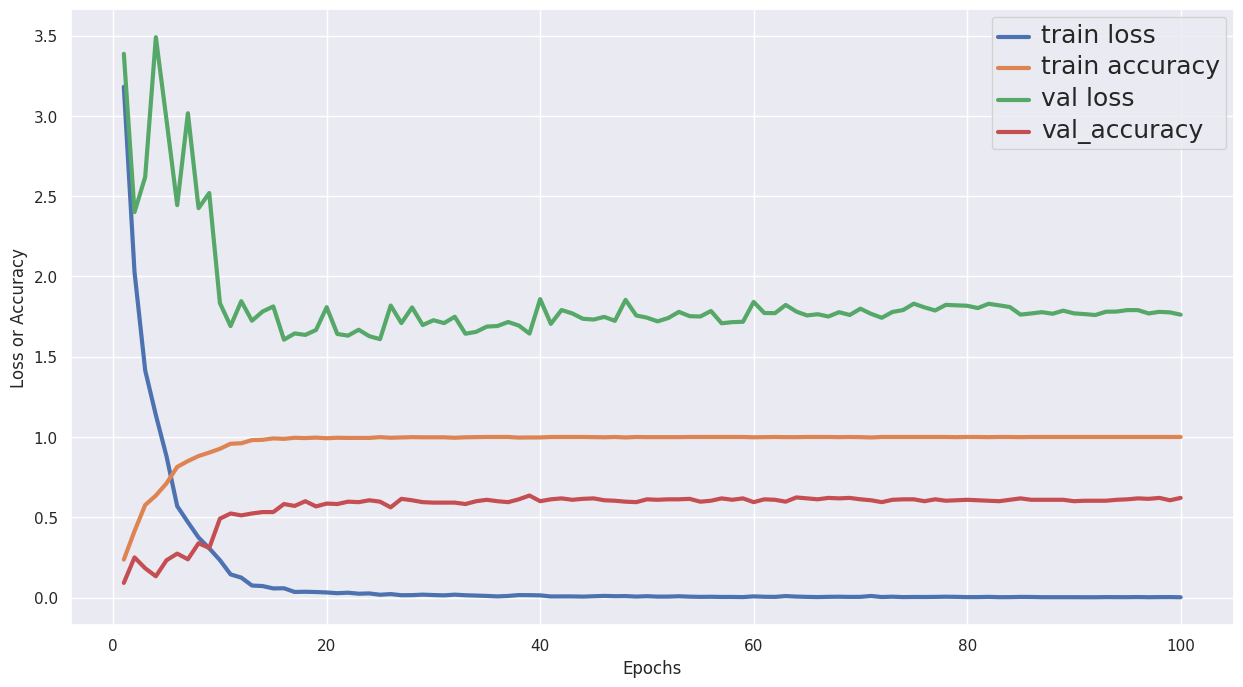

In [12]:
# evaluate the network
print ( "[INFO] evaluating network..." )
predictions = model.predict(testx, batch_size=32 )
print (classification_report(testy.argmax(axis=1 ),
predictions.argmax(axis=1 ), target_names=class_names))


# plot the performance
epochs = range(1,n_epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text